# 1. Install Required Packages

In [1]:
! pip install seqeval transformers datasets tokenizers seqeval evaluate -q

# 2. Import Necessary Libraries

In [2]:
import os
import re
import datasets
import json
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from datasets import load_dataset, Dataset
from transformers import AutoConfig, AutoTokenizer, AutoModel, AutoModelForTokenClassification, BertConfig, DataCollatorForTokenClassification, BertTokenizerFast, TrainingArguments, Trainer, EarlyStoppingCallback
from tqdm import tqdm

2024-05-10 19:30:58.658524: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 19:30:58.658640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 19:30:58.787238: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 3. Read and Load Data from JSON files

In [3]:
def process_json_file(file_path, tag_to_int=None, label_ids=None):
    if tag_to_int is None:
        tag_to_int = {}
        label_ids = {}
        unique_id = 0
    else:
        unique_id = len(tag_to_int)
    
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    token_data = []
    label_data = []
    
    for item in data:
        token_list = []
        label_list = []
        for token_info in item['tokens']:
            token = token_info['token']
            tag = token_info['tags'][0]['value']
            if tag not in tag_to_int:
                tag_to_int[tag] = unique_id
                label_ids[unique_id] = tag
                unique_id += 1
            token_list.append(token)
            label_list.append(tag_to_int[tag])
        token_data.append(token_list)
        label_data.append(label_list)
    
    result_dict = {'tokens': token_data, 'labels': label_data}
    return result_dict, tag_to_int, label_ids

def calculate_tag_frequencies(labels, label_ids):
    tag_counts = {}
    for sublist in labels:
        for label in sublist:
            tag_name = label_ids[label]
            if tag_name in tag_counts:
                tag_counts[tag_name] += 1
            else:
                tag_counts[tag_name] = 1
    return tag_counts

In [4]:
train_path = '/kaggle/input/wojoodner/subtask1/split70.json'
valid_path = '/kaggle/input/wojoodner/subtask1/split10.json'
test_path = '/kaggle/input/testwojood/split20-flat-unlabeled.json'

In [5]:
train_dataset, tag_to_int, label_ids = process_json_file(train_path)
valid_dataset, _, _ = process_json_file(valid_path, tag_to_int, label_ids)
test_dataset, _, _ = process_json_file(test_path)

train_ds = Dataset.from_dict(train_dataset)
valid_ds = Dataset.from_dict(valid_dataset)
test_ds = Dataset.from_dict(test_dataset)

tag_counts = calculate_tag_frequencies(train_dataset['labels'], label_ids)

# 4. Visualize Plots for Better Data Understanding

In [6]:
def plot_tag_frequency(tag_counts):
    tag_counts_series = pd.Series(tag_counts).sort_values(ascending=False)
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(x=tag_counts_series.values, y=tag_counts_series.index, palette="viridis")
    plt.title('Frequency of Each Tag')
    plt.xlabel('Frequency')
    plt.ylabel('Tags')
    plt.grid(True)
    
    for i, (value, name) in enumerate(zip(tag_counts_series.values, tag_counts_series.index)):
        ax.text(value, i, f'{value}', color='black', ha='left', va='center')
    
    plt.show()
    
def plot_sentence_length_distribution(sentences):
    sentence_lengths = [len(sentence) for sentence in sentences]
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(sentence_lengths, bins=30, kde=True, color='skyblue')
    plt.title('Sentence Length Distribution')
    plt.xlabel('Sentence Length (Tokens)')
    plt.ylabel('Frequency')

    mean_length = np.mean(sentence_lengths)
    median_length = np.median(sentence_lengths)

    plt.axvline(mean_length, color='r', linestyle='--')
    plt.text(mean_length, plt.ylim()[1] * 0.95, f'Mean: {mean_length:.2f}', color='red', ha='right')

    plt.axvline(median_length, color='g', linestyle='--')
    plt.text(median_length, plt.ylim()[1] * 0.90, f'Median: {median_length:.2f}', color='green', ha='left')

    plt.show()
    
def plot_entity_presence(labels, label_ids):
    labels_as_strings = [[label_ids[label] for label in sentence] for sentence in labels]
    num_entities_per_sentence = [sum(1 for label in sentence if label.startswith('B-')) for sentence in labels_as_strings]
    
    plt.figure(figsize=(10, 6))
    sns.histplot(num_entities_per_sentence, bins=max(num_entities_per_sentence) if num_entities_per_sentence else 1, kde=False, color='salmon')
    plt.title('Number of Entities per Sentence')
    plt.xlabel('Number of Entities')
    plt.ylabel('Frequency')
    
    mean_length = np.mean(num_entities_per_sentence)
    median_length = np.median(num_entities_per_sentence)

    plt.axvline(mean_length, color='r', linestyle='--')
    plt.text(mean_length, plt.ylim()[1] * 0.95, f'Mean: {mean_length:.2f}', color='red', ha='right')

    plt.axvline(median_length, color='g', linestyle='--')
    plt.text(median_length, plt.ylim()[1] * 0.90, f'Median: {median_length:.2f}', color='green', ha='left')
    
    plt.show()

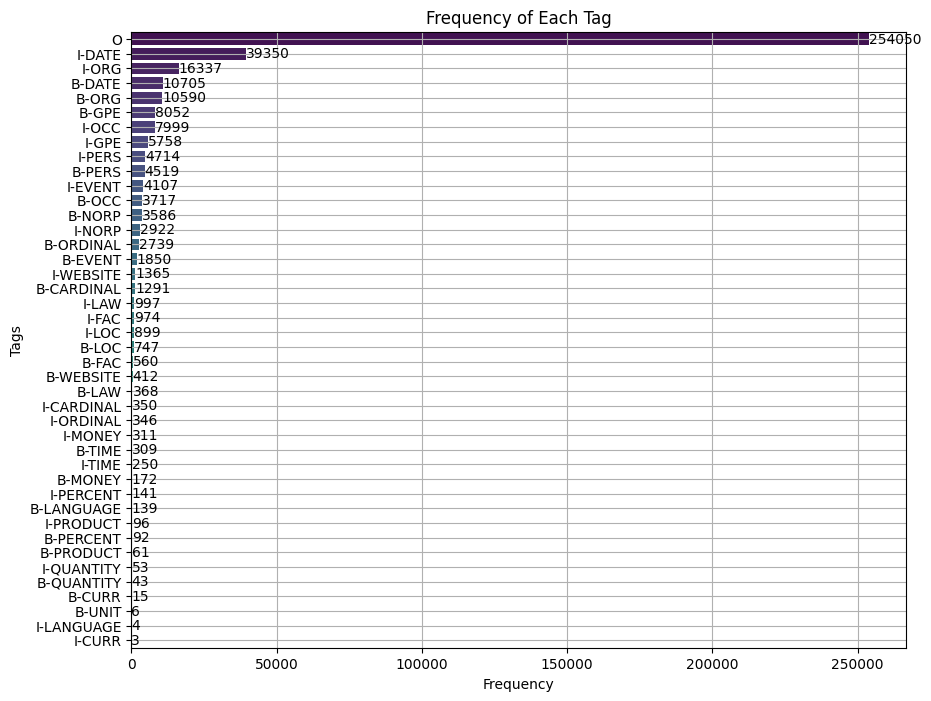

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


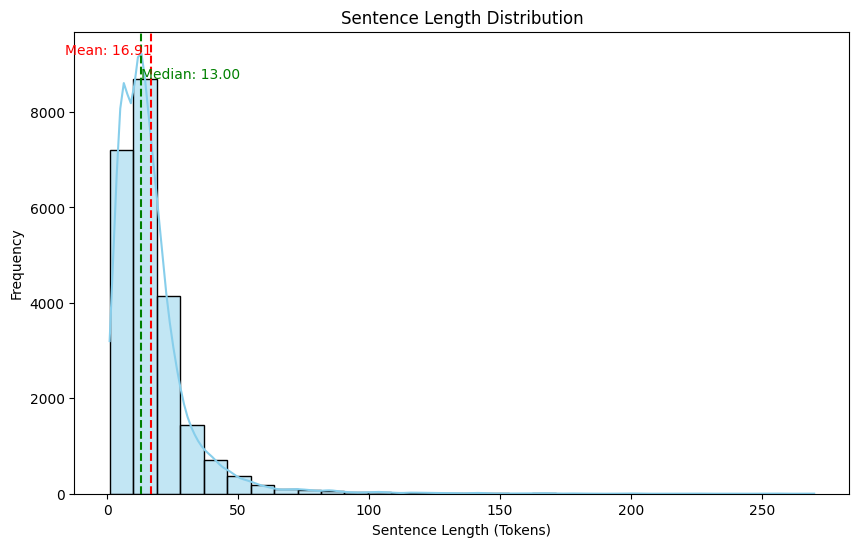

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


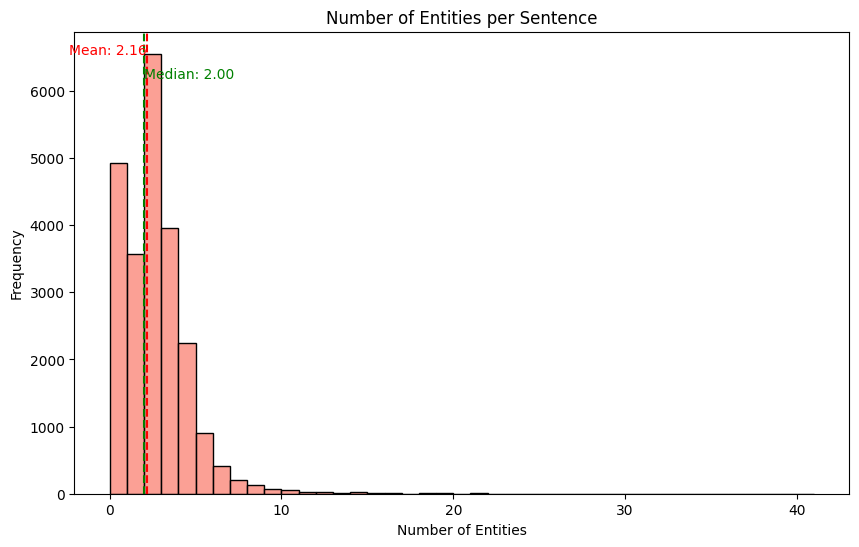

In [7]:
plot_tag_frequency(tag_counts)
plot_sentence_length_distribution(train_dataset['tokens'])
plot_entity_presence(train_dataset['labels'], label_ids)

# 5. Preprocess Data

In [8]:
def normalize_word(text):
    text_cleaned = re.sub(r'[يى]', 'ي', text)
    text_cleaned = re.sub(r'ة', 'ه', text_cleaned)
    text_cleaned = re.sub(r'[أإآ]', 'ا', text_cleaned)
    text_cleaned = re.sub(r'ک', 'ك', text_cleaned)
    return text_cleaned

def normalize_dataset(dataset):
    dataset['tokens'] = [normalize_word(token) for token in dataset['tokens']]
    return dataset

In [9]:
normalized_train_ds = train_ds.map(normalize_dataset, batched=False)
normalized_valid_ds = valid_ds.map(normalize_dataset, batched=False)
normalized_test_ds = test_ds.map(normalize_dataset, batched=False)

Map:   0%|          | 0/23125 [00:00<?, ? examples/s]

Map:   0%|          | 0/3304 [00:00<?, ? examples/s]

Map:   0%|          | 0/6606 [00:00<?, ? examples/s]

In [10]:
def tokenize_and_align_labels(examples, label_all_tokens=True): 
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = [] 
    for i, label in enumerate(examples["labels"]): 
        word_ids = tokenized_inputs.word_ids(batch_index=i) 
        previous_word_idx = None 
        label_ids = []
        for word_idx in word_ids: 
            if word_idx is None: 
                label_ids.append(-100)
            elif word_idx != previous_word_idx:               
                label_ids.append(label[word_idx]) 
            else: 
                label_ids.append(label[word_idx] if label_all_tokens else -100)                  
            previous_word_idx = word_idx 
        labels.append(label_ids) 
    tokenized_inputs["labels"] = labels 
    return tokenized_inputs 

In [11]:
model_path = "aubmindlab/bert-base-arabertv2"
# model_apth = "CAMeL-Lab/bert-base-arabic-camelbert-mix""
tokenizer = BertTokenizerFast.from_pretrained(model_path)
data_collator = DataCollatorForTokenClassification(tokenizer) 
metric = datasets.load_metric("seqeval") 

tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

/tmp/ipykernel_24/4206803956.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric("seqeval")
/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [12]:
tokenized_train_ds = normalized_train_ds.map(tokenize_and_align_labels, batched=True)
tokenized_valid_ds = normalized_valid_ds.map(tokenize_and_align_labels, batched=True)
tokenized_test_ds = normalized_test_ds.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/23125 [00:00<?, ? examples/s]

Map:   0%|          | 0/3304 [00:00<?, ? examples/s]

Map:   0%|          | 0/6606 [00:00<?, ? examples/s]

In [13]:
label_list = list(label_ids.values())

def compute_metrics(eval_preds): 
    pred_logits, labels = eval_preds 
    pred_logits = np.argmax(pred_logits, axis=2) 
    predictions = [ 
        [label_list[eval_preds] for (eval_preds, l) in zip(prediction, label) if l != -100] 
        for prediction, label in zip(pred_logits, labels) 
    ] 
    
    true_labels = [ 
      [label_list[l] for (eval_preds, l) in zip(prediction, label) if l != -100] 
       for prediction, label in zip(pred_logits, labels) 
   ] 
    results = metric.compute(predictions=predictions, references=true_labels) 
    return {
        "precision": results["overall_precision"], 
        "recall": results["overall_recall"], 
        "f1": results["overall_f1"], 
        "accuracy": results["overall_accuracy"], 
    }

In [14]:
def calculate_weights(tag_counts):
    total_tags = sum(tag_counts.values())
    weights = {tag: total_tags / count for tag, count in tag_counts.items()}

    max_weight = max(weights.values())
    weights_normalized = {tag: weight / max_weight for tag, weight in weights.items()}

    return list(weights_normalized.values())

def contrastive_loss(embeddings, labels, margin=1.0):
    similarity_matrix = F.cosine_similarity(embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=2)
    labels_matrix = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
    labels_matrix = 2 * labels_matrix - 1
    losses = 0.5 * (1 + labels_matrix) * torch.pow(1 - similarity_matrix, 2) + \
             0.5 * (1 - labels_matrix) * torch.pow(F.relu(similarity_matrix - margin), 2)
    
    return losses.mean()

def focal_loss(self, inputs, targets):
    gamma=2.
    ce_loss = F.cross_entropy(inputs, targets, reduction='mean', weight=weight, ignore_index=-100)
    pt = torch.exp(-ce_loss)
    focal_loss = (1 - pt) ** gamma * ce_loss
    
    return torch.mean(focal_loss)

weight = torch.tensor(calculate_weights(tag_counts), dtype=torch.float32)
weighted_loss = nn.CrossEntropyLoss(weight=weight)
num_labels = len(label_ids.values())

In [15]:
class ArabNERModelWithWeightedLoss(AutoModelForTokenClassification):
    def forward(self, input_ids, attention_mask=None, labels=None, **kwargs):
        outputs = super().forward(input_ids, attention_mask=attention_mask, **kwargs)
        if labels is not None:
            loss = weighted_loss(outputs.logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs[1:]
        return outputs
    
class ArabNERModelWithContrastiveLoss(AutoModelForTokenClassification):
    def forward(self, input_ids, attention_mask=None, labels=None, **kwargs):
        outputs = super().forward(input_ids, attention_mask=attention_mask, **kwargs)
        logits = outputs.logits
        loss = None
        if labels is not None:
            loss_f1 = weighted_loss(logits.view(-1, self.num_labels), labels.view(-1))
            embeddings = logits
            loss_f2 = contrastive_loss(embeddings, labels)
            loss = loss_f1 + 0.3 * loss_f2
        return (loss,) + outputs[1:] if loss is not None else outputs
    
class ArabNERModelWithFocalLoss(AutoModelForTokenClassification):
    def forward(self, input_ids, attention_mask=None, labels=None, **kwargs):
        outputs = super().forward(input_ids, attention_mask=attention_mask, **kwargs)
        logits = outputs.logits
        loss = None
        if labels is not None:
            loss_f1 = weighted_loss(logits.view(-1, self.num_labels), labels.view(-1))
            loss_f2 = focal_loss(logits.view(-1, self.num_labels), labels.view(-1))
            loss = loss_f1 + loss_f2
        return (loss,) + outputs[1:] if loss is not None else outputs

In [16]:
model = ArabNERModelWithWeightedLoss.from_pretrained(model_path, num_labels=num_labels)
# model = ArabNERModelWithFocalLoss.from_pretrained(model_path, num_labels=num_labels)

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
args = TrainingArguments(
    "Results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    weight_decay=0.01,
    report_to="tensorboard",
    load_best_model_at_end=True,
    save_total_limit=3,
    lr_scheduler_type='linear',
    warmup_ratio=0.1
)

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_valid_ds,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = model.to(device)
torch.cuda.empty_cache()

trainer.train()

Using device: cuda


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.481700,0.221022,0.816001,0.825540,0.820743,0.938640
2,0.198900,0.157526,0.874014,0.875847,0.874930,0.954389
3,0.122500,0.162625,0.835293,0.841825,0.838546,0.952184
4,0.072200,0.159579,0.872776,0.901483,0.886897,0.959705
5,0.051500,0.168375,0.884359,0.898904,0.891572,0.959470


/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

TrainOutput(global_step=7230, training_loss=0.26018723702859414, metrics={'train_runtime': 1336.2832, 'train_samples_per_second': 259.582, 'train_steps_per_second': 16.232, 'total_flos': 5498226620804412.0, 'train_loss': 0.26018723702859414, 'epoch': 5.0})

In [19]:
def find_last_created_folder(directory, prefix):
    if not os.path.exists(directory):
        print(f"The directory {directory} does not exist.")
        return None

    all_folders = [os.path.join(directory, f) for f in os.listdir(directory)]
    folders = [folder for folder in all_folders if os.path.isdir(folder) and os.path.basename(folder).startswith(prefix)]
    if not folders:
        print(f"No folders found in the directory that start with '{prefix}'.")
        return None

    last_created_folder = max(folders, key=os.path.getctime)

    return last_created_folder

directory_path = '/kaggle/working/Results/'
folder_prefix = 'checkpoint'
checkpoint_path = find_last_created_folder(directory_path, folder_prefix)

In [20]:
test_model = ArabNERModelWithFocalLoss.from_pretrained(checkpoint_path, num_labels=num_labels)
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)

In [21]:
from tqdm import tqdm
import torch

def predict_in_batches(model, tokenized_inputs, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_predictions = []
    input_ids = tokenized_inputs['input_ids']
    attention_mask = tokenized_inputs['attention_mask']

    for i in tqdm(range(0, input_ids.size(0), batch_size)):
        batch_input_ids = input_ids[i:i + batch_size].to(device)
        batch_attention_mask = attention_mask[i:i + batch_size].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            logits = outputs.logits
            predictions = logits.argmax(-1)
        all_predictions.append(predictions.cpu())
    return torch.cat(all_predictions, dim=0)

def map_predictions_to_original_tokens(predictions, tokenized_inputs, label_ids):
    word_level_predictions = []
    offset_mappings = tokenized_inputs['offset_mapping']
    word_ids = [tokenized_inputs.word_ids(batch_index=i) for i in range(predictions.size(0))]

    for idx, (preds, length) in enumerate(zip(predictions, tokenized_inputs['attention_mask'].sum(1))):
        current_word_ids = word_ids[idx]
        word_predictions = []
        previous_word_idx = None
        for word_idx, pred in zip(current_word_ids, preds[:length]):
            if word_idx is not None and word_idx != previous_word_idx:
                word_predictions.append(label_ids[pred.item()])
            previous_word_idx = word_idx
        word_level_predictions.append(word_predictions)

    return word_level_predictions

tokenized_inputs = tokenizer(test_ds['tokens'], is_split_into_words=True, padding=True, truncation=True, return_tensors="pt", return_offsets_mapping=True)
predictions = predict_in_batches(test_model, tokenized_inputs, batch_size=16)
word_level_predictions = map_predictions_to_original_tokens(predictions, tokenized_inputs, label_ids)

100%|██████████| 413/413 [01:45<00:00,  3.92it/s]


In [22]:
def format_predictions_to_conll(tokens_list, word_level_predictions):
    """Format the predictions to the CoNLL output format."""
    output = []
    for tokens, predictions in zip(tokens_list, word_level_predictions):
        for token, tag in zip(tokens, predictions):
            output.append(f"{token} {tag}")
        output.append("")
    return "\n".join(output)

def write_to_file(content, filename):
    """Write the given content to a text file."""
    with open(filename, "w", encoding="utf-8") as file:
        file.write(content)
    print(f"Data written to {filename}")

In [23]:
conll_output = format_predictions_to_conll(test_ds['tokens'], word_level_predictions)
write_to_file(conll_output, "/kaggle/working/ArabNER_subtask1_test_pred_2.txt")

Data written to /kaggle/working/ArabNER_subtask1_test_pred_2.txt
